In [1]:
import os
import json
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import defaultdict
from recsys.models import NeuMF
from recsys.data.movielens import MovielensSimpleDataset
from recsys.metrics.rank import hit_ratio_at_k, ndcg_at_k, mrr_at_k
from sklearn.metrics import roc_auc_score

In [2]:
with open("movielens/processed/num_sparse_features.json", "r") as f:
    num_sparse_features = json.load(f)
    
with open("movielens/processed/experiment_group.json", "r") as f:
    experiment_group = json.load(f)
experiment_group[NeuMF.model_name] = []

train = np.load("movielens/processed/train.npy")
test = np.load("movielens/processed/test.npy")

In [3]:
# Training Hyperparameter
batch_size = 64
latent_dim = 16
hidden_layers = [32, 32, 32]
lr = 1e-3
epochs = 10

# Define Dataset
train_ds = MovielensSimpleDataset(train, list(num_sparse_features.keys()))
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

device = torch.device("cpu")
model = NeuMF(num_sparse_features, latent_dim, hidden_layers)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)

NeuMF(
  (gmf): GeneralizedMatrixFactorization(
    (embeddings): ModuleDict(
      (user_id): Embedding(943, 16)
      (item_id): Embedding(1682, 16)
      (gender): Embedding(2, 16)
      (occupation): Embedding(21, 16)
      (genre): Embedding(19, 16)
    )
  )
  (ncf): NeuralCollaborativeFiltering(
    (embeddings): ModuleDict(
      (user_id): Embedding(943, 16)
      (item_id): Embedding(1682, 16)
      (gender): Embedding(2, 16)
      (occupation): Embedding(21, 16)
      (genre): Embedding(19, 16)
    )
    (mlp): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=32, bias=True)
      (5): ReLU()
    )
  )
  (classifier): Linear(in_features=48, out_features=1, bias=True)
)


In [4]:
# Train NeuMF
history = defaultdict(list)
model.train()
auc = 0
for epoch in range(epochs):
    total_loss = 0
    all_labels = []
    all_preds = []
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for sparse_features, labels in pbar:
        sparse_features = {k: v.to(device) for k, v in sparse_features.items()}
        labels = labels.to(device)

        
        # forward
        logits = model(sparse_features)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, labels)

        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        # metrics
        total_loss += loss.item()
        probs = logits.sigmoid().detach().cpu().numpy()
        all_preds.extend(probs.flatten())
        all_labels.extend(labels.detach().cpu().numpy().flatten())
        
        # tqdm update
        pbar.set_postfix(
            logloss=loss.item(),
            auc=f"{auc:.4f}"
            
        )

        
    avg_loss = total_loss / len(train_loader)
    acc = ((np.array(all_preds) > 0.5) == np.array(all_labels)).mean()
    auc = roc_auc_score(all_labels, all_preds)
    history["accuracy"].append(acc)
    history["auroc"].append(auc)
    history["logloss"].append(avg_loss)
    
    pbar.set_postfix(
        logloss=f"{avg_loss:.4f}",
        auc=f"{auc:.4f}"
    )
    pbar.refresh()

Epoch 1/10: 100%|█| 5747/5747 [00:15<00:00, 378.53it/s, auc=0.0000, logloss=0.38
Epoch 2/10: 100%|█| 5747/5747 [00:16<00:00, 344.13it/s, auc=0.7562, logloss=0.22
Epoch 3/10: 100%|█| 5747/5747 [00:17<00:00, 336.43it/s, auc=0.8235, logloss=0.49
Epoch 4/10: 100%|█| 5747/5747 [00:17<00:00, 330.65it/s, auc=0.8311, logloss=0.36
Epoch 5/10: 100%|█| 5747/5747 [00:17<00:00, 328.68it/s, auc=0.8388, logloss=0.48
Epoch 6/10: 100%|█| 5747/5747 [00:16<00:00, 339.11it/s, auc=0.8468, logloss=0.20
Epoch 7/10: 100%|█| 5747/5747 [00:15<00:00, 376.24it/s, auc=0.8580, logloss=0.40
Epoch 8/10: 100%|█| 5747/5747 [00:16<00:00, 355.09it/s, auc=0.8726, logloss=0.3]
Epoch 9/10: 100%|█| 5747/5747 [00:15<00:00, 369.64it/s, auc=0.8869, logloss=0.24
Epoch 10/10: 100%|█| 5747/5747 [00:13<00:00, 433.21it/s, auc=0.8991, logloss=0.3


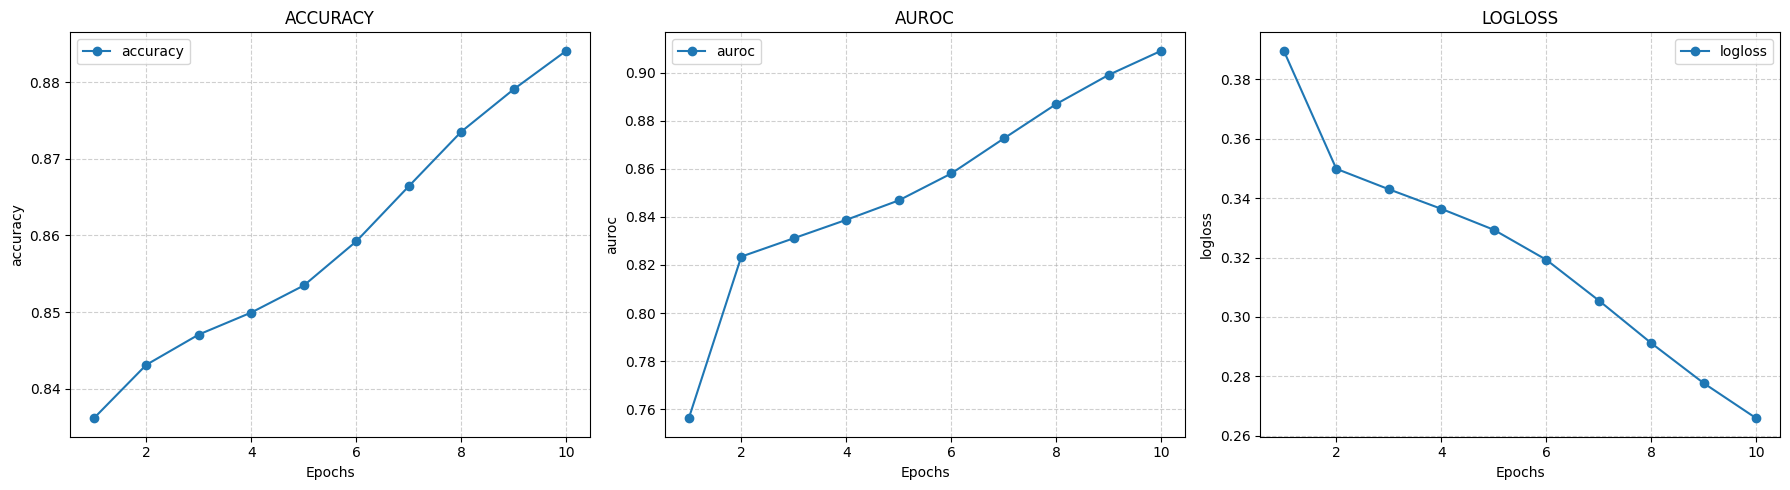

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

for i, metrics in enumerate(history):
    ax = axes[i]

    ax.plot(range(1, epochs+1), history[metrics], marker="o", label=metrics)
    ax.set_title(metrics.upper())
    ax.set_xlabel("Epochs")
    ax.set_ylabel(metrics)
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

In [6]:
# Recommendation
user_recommendations = {}
model.eval()
with torch.no_grad():
    all_item_indices = torch.arange(num_sparse_features["item_id"]).to(device)
    pbar = tqdm(range(num_sparse_features["user_id"]), desc="Recommend")
    for user_id in pbar:
        sparse_features = {
            "user_id":torch.full(size=(len(all_item_indices),), fill_value=user_id).to(device),
            "item_id":all_item_indices,
        }
        logits = model(sparse_features)
        indices = logits.flatten().argsort(descending=True)
        

        user_recommendations[user_id] = indices.detach().cpu().numpy()

        pbar.set_postfix(user_id=user_id)

Recommend: 100%|████████████████| 943/943 [00:01<00:00, 841.26it/s, user_id=942]


In [7]:
ks = [5, 10, 15, 20]
hr = defaultdict(float)
ndcg = defaultdict(float)
mrr = defaultdict(float)

for line in test:
    user_id, item_id, _ = line
    recs = user_recommendations[user_id]
    experiment_group[model.model_name] = recs

    # calculate
    for k in ks:
        for m in experiment_group:
            hr[f"{m}@{k}"] += hit_ratio_at_k(experiment_group[m], item_id, k)
            ndcg[f"{m}@{k}"] += ndcg_at_k(experiment_group[m], item_id, k)
            mrr[f"{m}@{k}"] += mrr_at_k(experiment_group[m], item_id, k)
    
    
hr = {k: np.round(v/len(test), 4) for k,v in hr.items()}
ndcg = {k: np.round(v/len(test), 4) for k,v in ndcg.items()}
mrr = {k: np.round(v/len(test), 4) for k,v in mrr.items()}

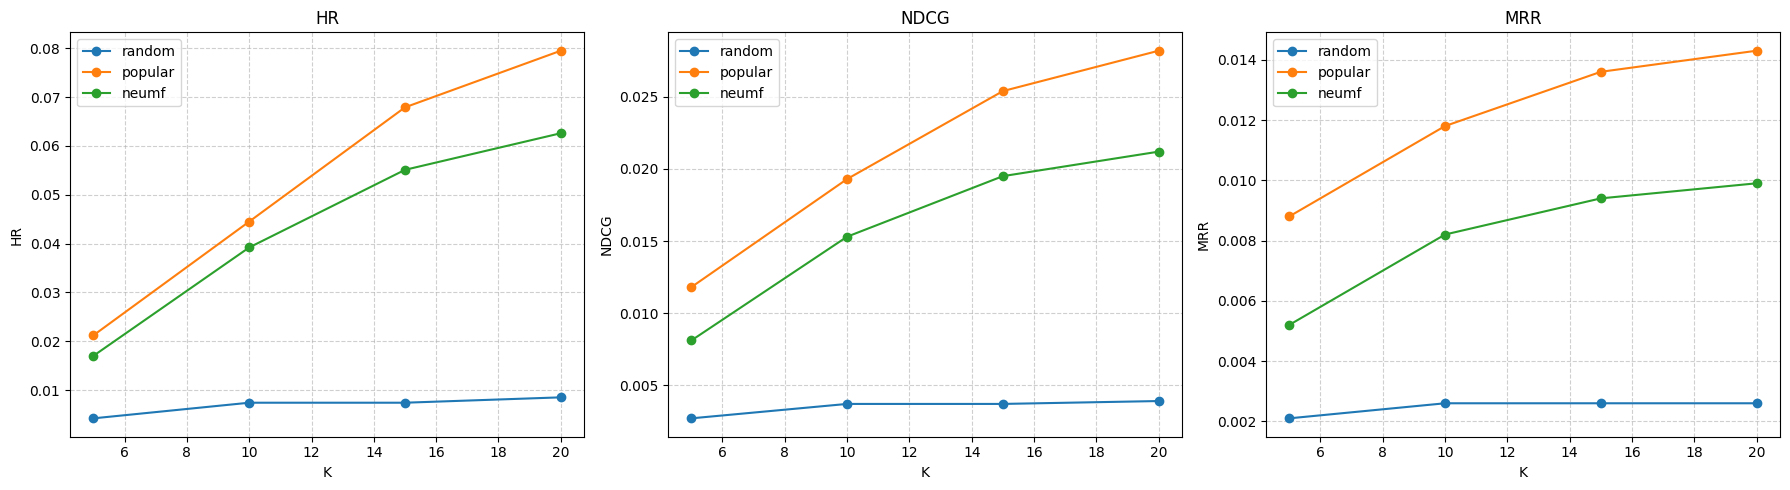

In [8]:
metrics = {"HR": hr, "NDCG": ndcg, "MRR": mrr}


fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

for ax, (metric_name, metric_dict) in zip(axes, metrics.items()):
    for m in experiment_group:
        values = [metric_dict[f"{m}@{k}"] for k in ks]
        ax.plot(ks, values, marker="o", label=m)

    ax.set_title(metric_name.upper())
    ax.set_xlabel("K")
    ax.set_ylabel(metric_name)
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()